### Gaussian and Student-T processes for ITSLIVE glacier surface velocity timeseries - A bit of probabilistic modeling


In [1]:
## import modules to do the heavy lifiting for us
import pymc as pm
import numpy as np
import celerite2
from celerite2 import terms
import emcee
from scipy.optimize import minimize

## import pandas for time series management
import pandas as pd

## some plot and stuff
import matplotlib.pyplot as plt
import seaborn as sns

## We want fonts to be big without using matplotlib.rc.params
sns.set(context="talk", style="ticks")

## Modules for book-keeping
import os
import sys
from dataclasses import dataclass
from abc import ABC, abstractmethod
import functools
from typing import Sequence

#### Data preprocessing

In [2]:
def preprocess_velocity_dataframe(
    filename: str, baseline_threshold: int = 60
) -> pd.DataFrame:
    """I am a function that takes a filename as an input. I return a pandas dataframe that has been preprocessed. In this example, I remove temporal baselines above a certain threshold, given as an optional input, and redefine the temporal coordinate as decimal years"""
    ## import the data and set its index to be the date\
    df = pd.read_csv(filename)
    df = pd.read_csv(filename).set_index(pd.to_datetime(df["mid_date"])).sort_index()
    # normalization_factor = np.nanmedian(df["v [m/yr]"])
    # df = df[df.index > pd.to_datetime("20-01-01")]
    df["days_since"] = (df.index - df.index[0]).days.values
    df["dec_year"] = (df.index.year + (df.index.dayofyear - 1) / 365).values

    ## Higher baseline are typically uninformative - so we remove them and keep only data with temporal baseline < baseline_threshold
    df = df[df["date_dt [days]"] < baseline_threshold]
    return df.dropna()

In [3]:
## We'll use data from Jakobshavn Glacier in Greenland
dirname = sys.path[0]
filename = os.path.join(dirname, "data/LAT69.1117--LON-49.4604.csv")
velocity_dataframe = preprocess_velocity_dataframe(filename)

Now let's declare a few classes and methods to help through the whole process:
- The first one is what's called an Abstract Base Class (ABC). Going deep into what's an ABC is beyond the scope of this notebook but we encourage the reader to read more on [ABCs](https://docs.python.org/3/library/abc.html), they are a great tool for object oriented progamming.
- Then we will define a few methods for plotting to keep the code concise and readable throughout.

In [4]:
## Abstract base classes
## Provides a common architecture to all GPs classes defined and used
class VelocityGP(ABC):
    @property
    @abstractmethod
    def define_gp(self):
        pass

    @abstractmethod
    def mu(self):
        pass

    @abstractmethod
    def stdev(self):
        pass

    @abstractmethod
    def residuals(self):
        pass


## Plotting functions
def plot_fit(t, y, yerr, gp: VelocityGP):
    true_t = np.linspace(t[0], t[-1], len(t))

    plt.figure(figsize=(30, 5))
    plt.errorbar(x=t, y=y, yerr=yerr, fmt=".k", alpha=0.2)
    plt.plot(true_t, gp.mu())
    plt.fill_between(
        true_t,
        gp.mu() - gp.stdev(),
        gp.mu() + gp.stdev(),
        alpha=0.5,
    )

    t0 = velocity_dataframe["mid_date"].values.astype("datetime64[D]")[0]
    plt.xlabel(f"Time since t0={t0} [days]")
    plt.ylabel("Surface velocity [m/year]")

#### Gaussian Processes


In the following, we use the _celetire2_ (https://celerite2.readthedocs.io/en/latest/) implementaiton of Gaussian processes to define our 1D GP to be fitted to our data.


While we will provide a succinct description of how _celerite2_ implements GPs, we strongly recommend the reader to go back to the source material for more technical details : [Foreman-Mackey et al., 2017](https://iopscience.iop.org/article/10.3847/1538-3881/aa9332).


Here, we model "glacier behavior" using a surrogate model - the underlying is that we have some sort of knowledge on how glacier velocity evolves in time, without having to solve for any glacier evolution equations. We could do that with a lot of different models - harmonic functions or splines for example - but GPs offers a lot of flexibility, by enabling a quick and easy formulation of the problem as a probabilistic inference exercise.

DESCRIBE THE COVARIANCE A BIT MORE

_celetire2_'s stochastically-driven, damped harmonic oscillator term allows to do that just fine. It also provides an easily tractable and intuitive parametrization through three main terms :
- $\rho$ : the undamped period of the oscillator (in time units, here: $yr$)
- $\tau$ : the damping timescale of the oscillator (also in time units). This bascially is the characteristic time it takes for the amplitude of the oscillations to decrease by a factor of $\mathrm{e}$
- $\sigma$: the standard deviation of the process, in units of the latent variable, so here $m/yr$

Okay, now we know how to model our glacier behavior, let's start by defining a few classes and methods:

In [5]:
@dataclass(frozen=True)
class SimpleGP(VelocityGP):
    """I am a class that implements the celirte2 GaussianProcess class and inherit methods from the VelocityGP abstract base class.
    I am defined through 3 data array as inputs - y : the data values, t : the associated time dimension, yerr : the array of measurement errors and params : a set of parameters to be minimized to fit the data array.
    In the present case we only minimize the sigma parameter of each kernel term - increasing the number of parameters to be minimized will lead to instabilities
    """

    t: Sequence
    y: Sequence
    yerr: Sequence
    params: Sequence

    @functools.cached_property
    def define_gp(self) -> celerite2.GaussianProcess:
        term1 = terms.SHOTerm(
            sigma=self.params[0], rho=self.params[1], tau=self.params[2]
        )
        kernel = term1
        gp = celerite2.GaussianProcess(kernel, mean=np.nanmedian(self.y))
        gp.compute(t=self.t, diag=self.yerr**2)
        return gp

    def mu(self) -> Sequence[np.float64]:
        true_t = np.linspace(self.t[0], self.t[-1], len(self.y))
        return self.define_gp.predict(self.y, t=true_t, return_var=False)

    def stdev(self) -> Sequence[np.float64]:
        true_t = np.linspace(self.t[0], self.t[-1], len(self.y))
        var = self.define_gp.predict(self.y, t=true_t, return_var=True)[-1]
        return np.sqrt(var)

    def residuals(self) -> Sequence[np.float64]:
        return self.y - self.mu()

(0.0, 15000.0)

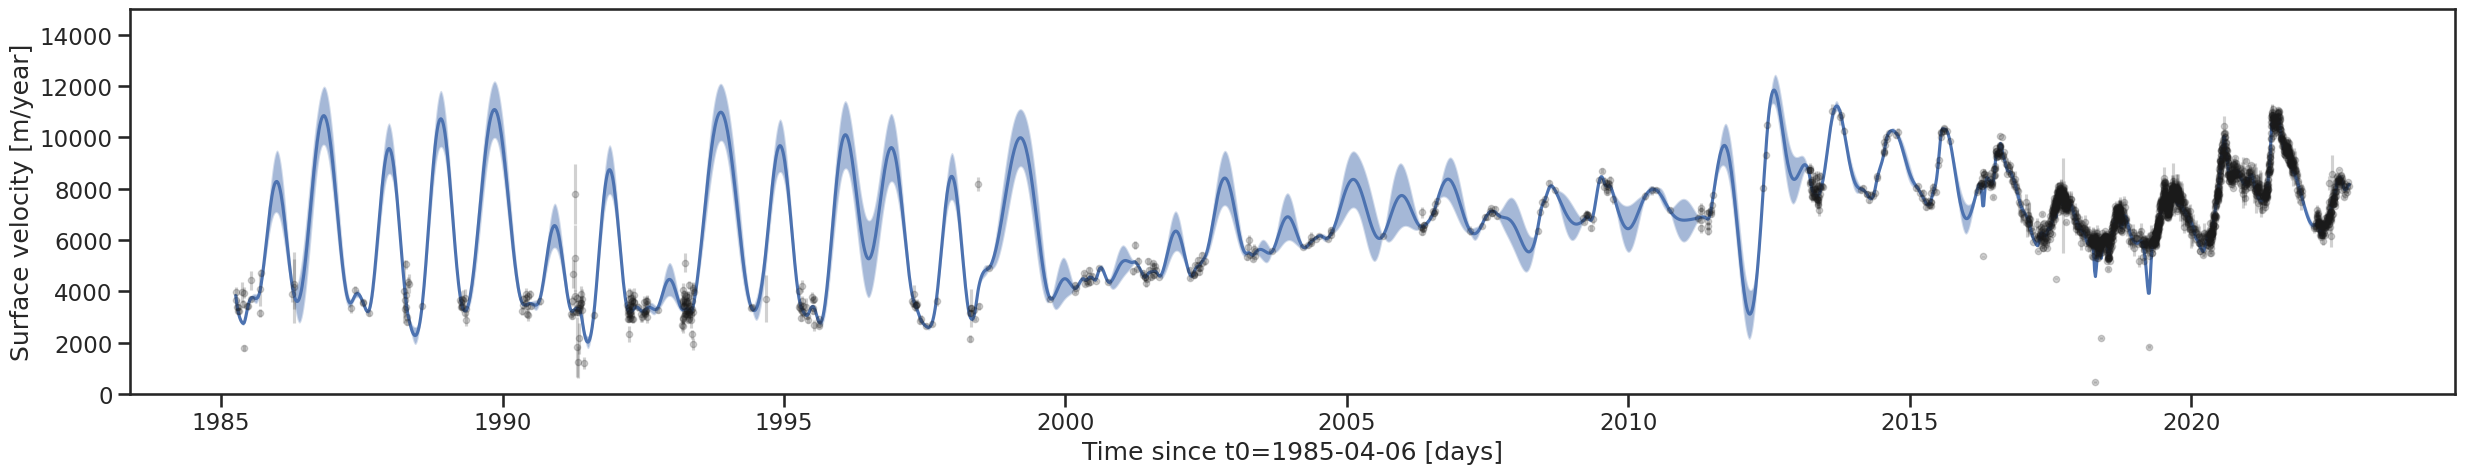

In [6]:
## Defining inputs
t = velocity_dataframe["dec_year"].values
y = velocity_dataframe["v [m/yr]"].values
yerr = velocity_dataframe["v_error [m/yr]"].values

## First guess on GP hyperprameters : [rho, tau, sigma, jitter]
initial_params = [5000, 1, 10]
jakobshavn_gp = SimpleGP(t=t, y=y, yerr=yerr, params=initial_params)


plot_fit(t, y, yerr, gp=jakobshavn_gp)
plt.ylim(0, 15000)

Okay, this is pretty bad - we can definitely do better.

A few points to look at :
- the model variance is controlled only by seasonal variations - that's why we have unreasonably high amplitudes in the earlier years.
- the model is also very confident in itself : errorbars are abnormally low when we lack data and when the model significantly diverges from the observations.

It is however unlikely for the covariance matrix to be as simple as we wrote it - we typically expect to see more than one harmonic mode when decomposing a glacier surface velocity time-series and, so far, we account only for yearly variations.

Similarly, sub-yearly, abrupt variations in velocity are common on glaciers, especially in tidewater glaciers, when summer melt creates an influx of meltwater that enhances glacier sliding.\
Let's write a new GP class that accounts for all of that.

In [7]:
@dataclass(frozen=True)
class DoubleComponentGP(VelocityGP):
    """I am a class that implements the celirte2 GaussianProcess class and inherit methods from the VelocityGP abstract base class.
    I am defined through 3 data array as inputs - y : the data values, t : the associated time dimension, yerr : the array of measurement errors and params : a set of parameters to be minimized to fit the data array.
    In the present case we only minimize the sigma parameter of each kernel term - increasing the number of parameters to be minimized will lead to instabilities
    """

    t: Sequence
    y: Sequence
    yerr: Sequence
    params: Sequence

    @functools.cached_property
    def define_gp(self) -> celerite2.GaussianProcess:
        term1 = terms.SHOTerm(sigma=5000, rho=1, tau=self.params[2])
        term2 = terms.SHOTerm(sigma=self.params[3], rho=self.params[4], Q=0.1)
        kernel = term1 + term2
        gp = celerite2.GaussianProcess(kernel, mean=np.nanmedian(self.y))
        gp.compute(t=self.t, diag=self.yerr**2, quiet=True)
        return gp

    def mu(self) -> Sequence[np.float64]:
        true_t = np.linspace(self.t[0], self.t[-1], len(self.y))
        return self.define_gp.predict(self.y, t=true_t, return_var=False)

    def stdev(self) -> Sequence[np.float64]:
        true_t = np.linspace(self.t[0], self.t[-1], len(self.y))
        var = self.define_gp.predict(self.y, t=true_t, return_var=True)[-1]
        return np.sqrt(var)

    def residuals(self) -> Sequence[np.float64]:
        return self.y - self.mu()

Now, this is using only our guess on the parameters for each term of our covariance matrix.
Clearly the fit is not great but we are getting there.
However, the GP is predicting negative velocity values, which I'm not very happy about.

Let's see if we can numerically optimize our model and find a set of parameters that would fit this.


For this, we are going to find the set of parameters that maximizes the likelihood of our model.\
In practice, and because it's simpler mathematically, we will minimize the negative log likelihood instead of maximizing the likelihood.\
Let's first write a simple method that does that for us.\
Thankfully, _celerite_ GP models are already implemented with a *log_likelihood* method we can use.\
Our data is noisy so we will use the Powell method for optimizing; more on that can be found through [SciPy's documentation](https://scipy-lectures.org/advanced/mathematical_optimization/#choosing-a-method).

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 79014.90820254314
             x: [ 4.642e+03  1.895e+00  5.000e+00  3.000e+03  1.000e+00
                  1.757e+01  4.538e+01]
           nit: 67
          nfev: 270
 final_simplex: (array([[ 4.642e+03,  1.895e+00, ...,  1.757e+01,
                         4.538e+01],
                       [ 4.642e+03,  1.895e+00, ...,  1.757e+01,
                         4.538e+01],
                       ...,
                       [ 4.642e+03,  1.895e+00, ...,  1.757e+01,
                         4.538e+01],
                       [ 4.642e+03,  1.895e+00, ...,  1.757e+01,
                         4.538e+01]]), array([ 7.901e+04,  7.901e+04,  7.901e+04,  7.901e+04,
                        7.901e+04,  7.901e+04,  7.901e+04,  7.901e+04]))

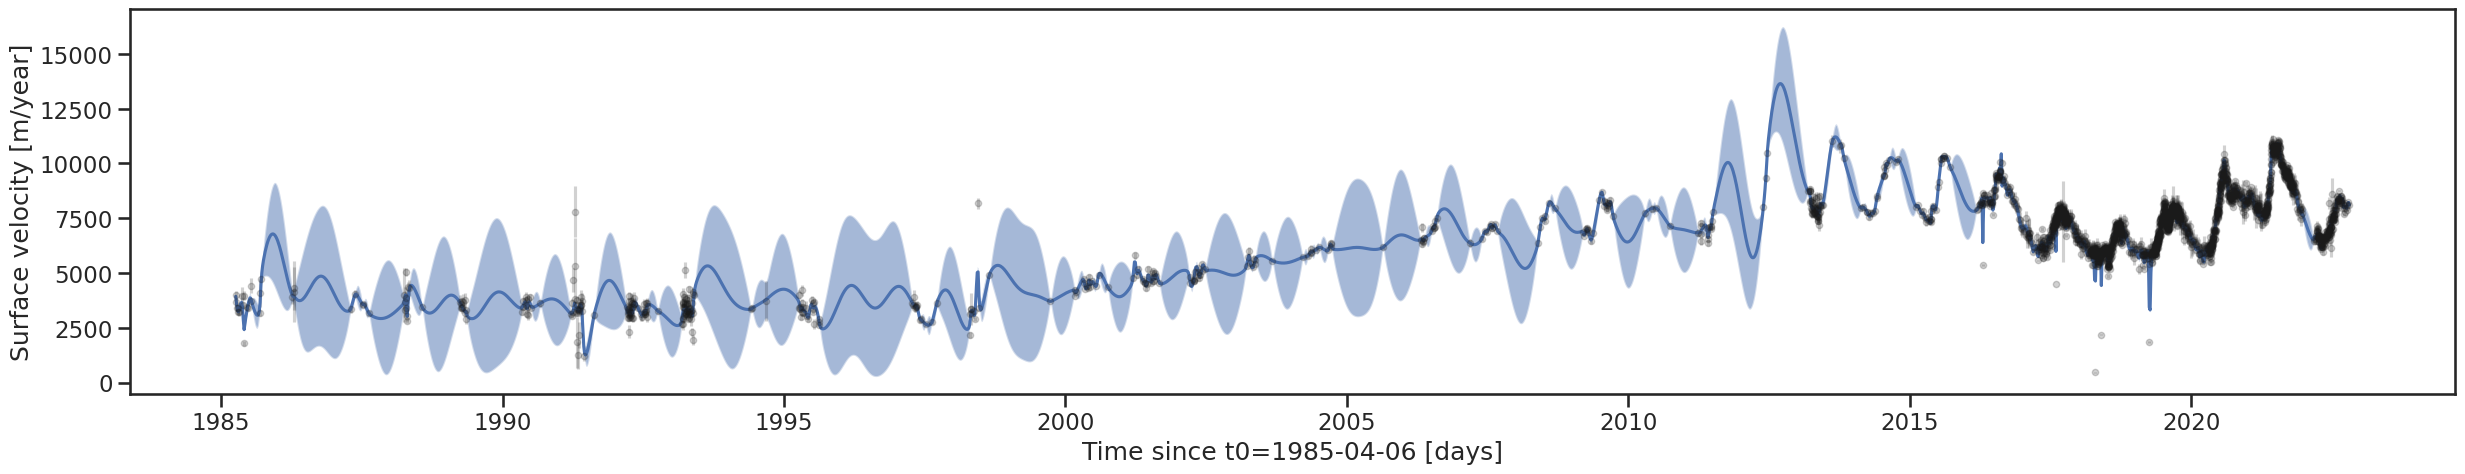

In [8]:
## GP methods
def neg_log_like(
    params: Sequence,
    t: Sequence,
    y: Sequence,
    yerr: Sequence,
):
    gp = DoubleComponentGP(
        t=t,
        y=y,
        yerr=yerr,
        params=params,
    ).define_gp
    return -gp.log_likelihood(y)


### Define bounds for each parameter - mostly we want to prevent any LinAlgError or matrices being not PSD
bounds = (
    (2000, 7000),
    (1, 10),
    (5, 20),
    (1000, 3000),
    (1, 10),
    (5, 20),
    (5, 50),
)

### That's our first guess on parameters
initial_params = [5000, 1, 10, 2000, 5, 10, 40]

minima = minimize(
    neg_log_like,
    initial_params,
    method="Nelder-Mead",
    bounds=bounds,
    args=(
        t,
        y,
        yerr,
    ),
)
opt_jakobshavn_gp = DoubleComponentGP(
    t=t,
    y=y,
    yerr=yerr,
    params=minima.x,
)

plot_fit(t, y, yerr, gp=opt_jakobshavn_gp)
minima

Well this is definitely looking much better - it's not perfect but no model is.\
We could add more parameters to the model, to capture more variability in the data but whether or not it makes physical sense to do so is way beyond the scope of what we are doing here.

Instead, let's try to get an idea of the uncertainty of our parameters.

When we minimized the likelihood earlier, we used bounds to direct the search of the parameter space.
In a world where model parameters are formulated as distributions, we thus assumed every value over this interval to be equally plausible.\
In other words, we assumed the distribution of plausible values for each parameters to be uniform.\
While it helped a bit, it's not a very informative process, and we might want to define some parameters more precisely, with other types of distributions.

Let's do that right now - _celerite2_ includes support for probabilistic modeling using  [_emcee_](https://emcee.readthedocs.io/en/stable/), an ensemble sampler.

A word of caution : it's very likely that $\rho$ and $\tau$ are degenerate parameters, in a way that the damping period of an oscillator and its timescale are likely heavily correlated. This is something to monitor as it could impact the inference result

In [9]:
import emcee

sigma_priors = [100, 0.1, 0.2, 100, 0.2, 0.1, 0.1]
initial_params = [5000, 1, 10, 2000, 5, 10, 10]


def log_prob(
    params: Sequence,
    t: Sequence,
    y: Sequence,
    yerr: Sequence,
):
    gp = DoubleComponentGP(
        t=t,
        y=y,
        yerr=yerr,
        params=initial_params,
    ).define_gp
    return gp.log_likelihood(y) - 0.5 * np.sum((params / sigma_priors) ** 2)


np.random.seed(5693854)
ndim, nwalkers = len(initial_params), len(initial_params) * 2
pos = [minima.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers,
    ndim=ndim,
    log_prob_fn=log_prob,
    args=(t, y, yerr),
)
state = sampler.run_mcmc(pos, 100, progress=False)
sampler.reset()
state = sampler.run_mcmc(state, 5000, progress=False)

/home/gregguillet/miniforge3/envs/pymc_env2/lib/python3.11/site-packages/celerite2/numpy.py:32: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.random.multivariate_normal(mu, cov, size=size)


<ErrorbarContainer object of 3 artists>

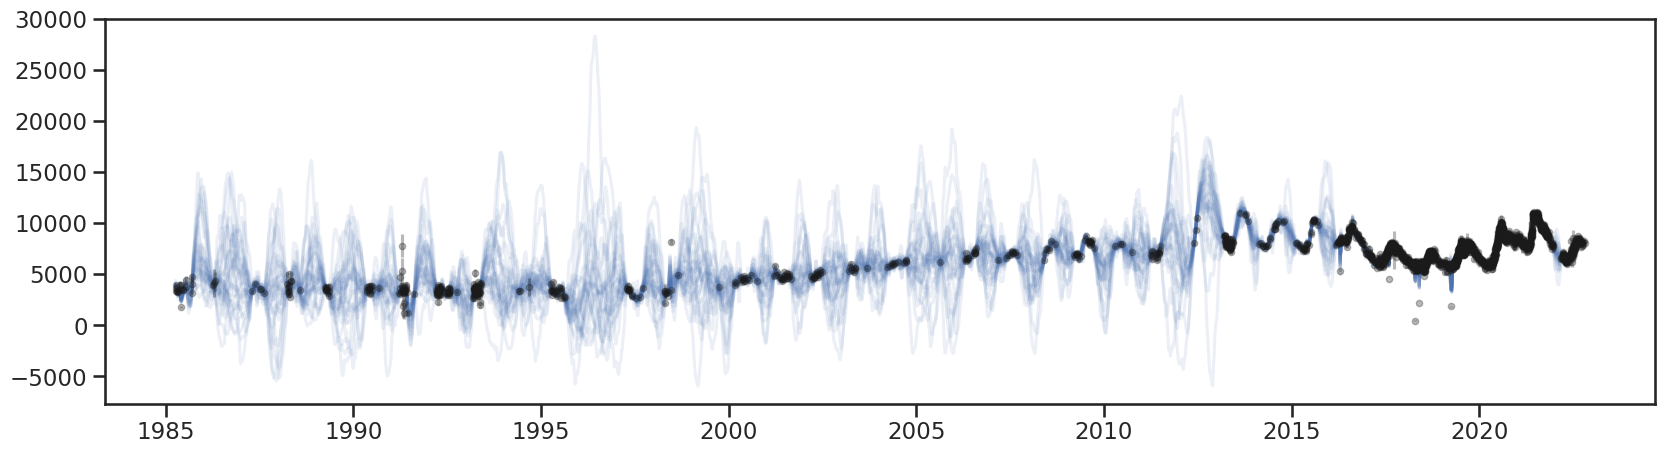

In [10]:
chain = sampler.get_chain(discard=100, flat=True)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
true_t = np.linspace(t[0], t[-1], len(t))
for sample in chain[np.random.randint(len(chain), size=100)]:
    try:
        gp = gp = DoubleComponentGP(
            t=t,
            y=y,
            yerr=yerr,
            params=sample,
        ).define_gp
        conditional = gp.condition(y, true_t)
        ax.plot(true_t, conditional.sample(), color="C0", alpha=0.1)
    except AttributeError:
        pass


plt.errorbar(t, y, yerr=yerr, fmt=".k", alpha=0.3)

## This cell is gonna run for a bit - typically 5 mins - on my 20 cores.

Okay it's not bad for a model we came up with in 10 minutes minus running time.

Ideally, litterature review would guide our prior definition, instead of me just guessing from what I know, or rahter don't know, about Jakobshavn Isbrae.\
Here, I hardcoded a lot of parameters values - this is not ideal and a true Bayesian would mostly propose a hierarchical model, with hyperpriors - but this is way beyond of the scope of what we are doing here.

Let's rather look at the figure above in more detail:
- Because we imposed Gaussian priors, some of our walkers get lost and actually predict negative velocity values which of course make no physical sense. To alleviate this, one could use a distribution that allows only for positive values, such as an exponential, a Gamma or a half-Gaussian.\
We should also have used more informative priors but I kept them really loose on purpose, meaning that the spread of the distribution for each parameter is quite large.
- One thing makes me unhappy, and this is those negative peaks between 2018 and 2020. They originate from the outliers we see in that period, that have an abnormally low error bar.\
Our GP here tries to fit them because of this, which is clearly suboptimal. There are different ways to deal with problems like these: 1\) one could use iterative [sigma-clipping](https://www.gnu.org/software/gnuastro/manual//html_node/Sigma-clipping.html) with different sigma thresholds to remove the outliers by sequentially fitting different GPs, 2) one could try to use a more robust model, relying on a overdispersed Gaussian - AKA a Student-T distribution - which, unlike the normal distribution is robust to outliers.

Let's try to implement a Student-T Process.

#### Student-T processes

/home/gregguillet/miniforge3/envs/pymc_env2/lib/python3.11/site-packages/pymc/distributions/multivariate.py:364: FutureWarning: Use the scale argument to specify the scale matrix. cov will be removed in future versions.
  warnings.warn(


Text(0.5, 1.0, 'Samples from GP')

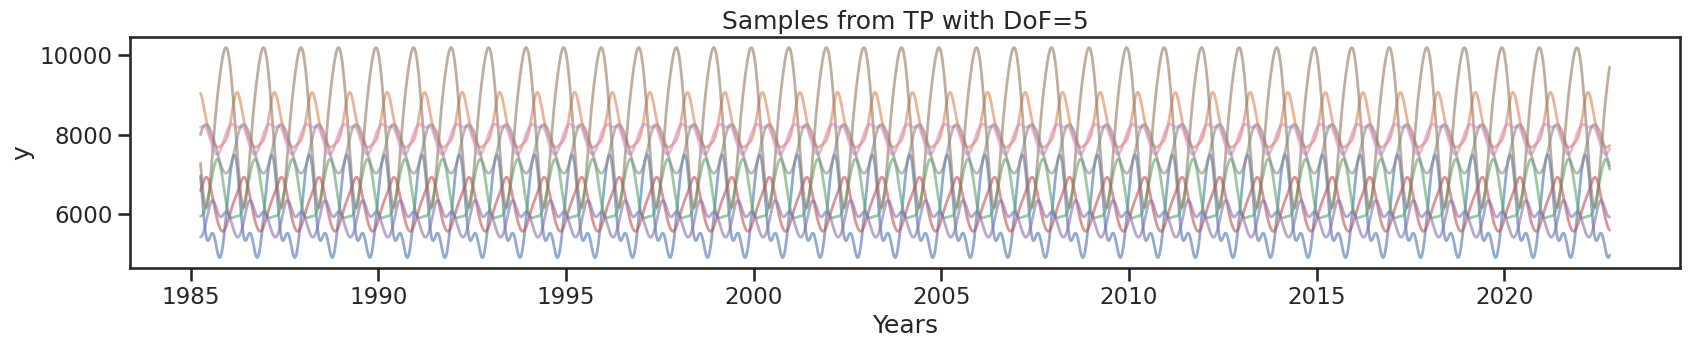

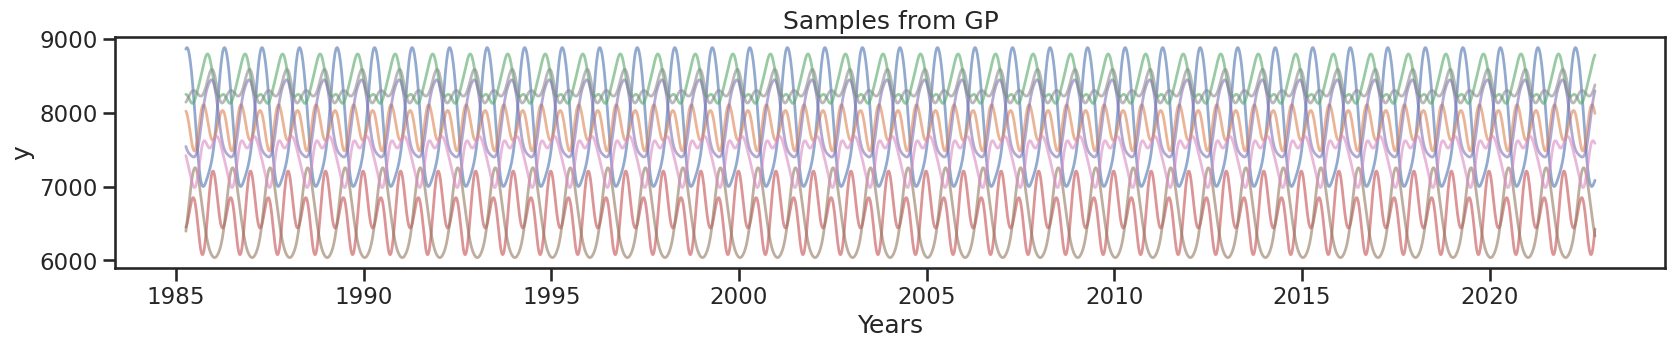

In [11]:
# set the seed
rng42 = np.random.seed(42)


## We need to unpack t as a column vector
t_ = t[:, None]

## Let's
n = len(t)  # The number of data points
X = np.linspace(t[0], t[-1], n)[
    :, None
]  # Inputs to the GP - must be arranged as a column vector

# Define the covariance function and its parameters - ls is the lengtscale parameter, and period is the period -- naturally.
cov_func = (1000**2) * pm.gp.cov.Periodic(input_dim=1, period=1, ls=1)

# A mean function that is the median of the velocity value everywhere
mean_func = pm.gp.mean.Constant(np.nanmedian(y))

tp_samples = pm.draw(
    pm.MvStudentT.dist(mu=mean_func(X).eval(), cov=cov_func(X).eval(), nu=5), 8
)

## Plot samples from TP prior
fig = plt.figure(figsize=(20, 3))
ax = fig.gca()
ax.plot(X.flatten(), tp_samples.T, lw=2, alpha=0.6)
ax.set_xlabel("Years")
ax.set_ylabel("y")
ax.set_title("Samples from TP with DoF=5")


gp_samples = pm.draw(
    pm.MvNormal.dist(mu=mean_func(X).eval(), cov=cov_func(X).eval()), 8
)
fig = plt.figure(figsize=(20, 3))
ax = fig.gca()
ax.plot(X.flatten(), gp_samples.T, lw=2, alpha=0.6)
ax.set_xlabel("Years")
ax.set_ylabel("y")
ax.set_title("Samples from GP")

All right, so we just plotted two different priors here.

One is the T-Process with $n=5$ degrees of freedom (value chosen to follow best practices for robust inference, as described in [Gelman et al.'s book](http://www.stat.columbia.edu/~gelman/book/)), the other is the GP.\
We can already see that the TP allows for a wider range of behaviors (within a signle model), compared to the GP.


Okay now let's provide a continuous estimate of the glacier velocity. We have to sample the posterior distribution and this can take a lot of time, so we'll slice and resample the time series.


<ErrorbarContainer object of 3 artists>

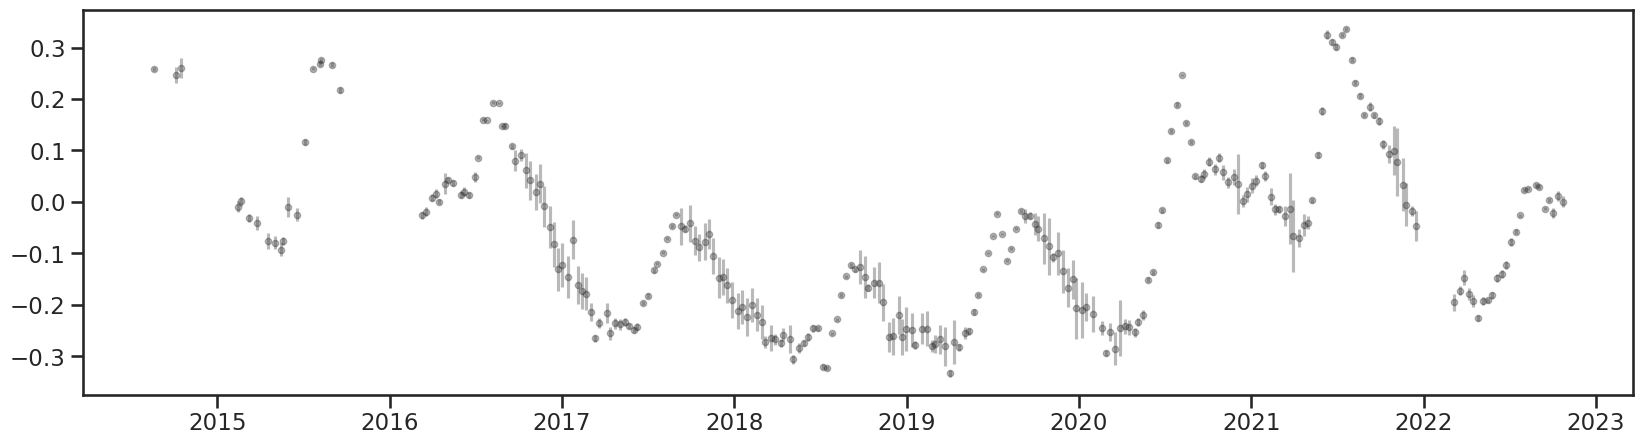

In [36]:
## Resampling
velocity_dataframe_resample = velocity_dataframe.resample("10D").median(
    numeric_only=True
)

## Re-assigning new input variables
y_resampled = velocity_dataframe_resample["v [m/yr]"].values
yerr_resampled = velocity_dataframe_resample["v_error [m/yr]"].values
t_resampled = velocity_dataframe_resample["dec_year"].values


n = 300  # let's focus only on the last 4 years (365*4/sampling_rate)
y_slice = (y_resampled[-n:] - y_resampled[-1]) / y_resampled[-1]
y_err_slice = (yerr_resampled[-n:]) / y_resampled[-1]
X_slice = np.linspace(t_resampled[-n], t_resampled[-1], n)[:, None]

## Adding a plot to make sure we haven't lost too much data by resampling
plt.figure(figsize=(20, 5))
plt.errorbar(t_resampled[-n:], y=y_slice, yerr=y_err_slice, fmt=".k", alpha=0.3)

In [38]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=5, beta=1)
    # eta = pm.Gamma("eta", mu=2, sigma=0.5)
    cov = pm.gp.cov.Matern52(1, ell)

    tp = pm.gp.TP(cov_func=cov, nu=5)
    f = tp.prior("f", X=X_slice)

    y_ = pm.StudentT("y", mu=f, sigma=0.1, nu=5, observed=y_slice)

    idata = pm.sample(500, tune=100, chains=2)

## Sampling is going to take around 15-20 minutes - go get a coffee

/home/gregguillet/miniforge3/envs/pymc_env2/lib/python3.11/site-packages/pymc/gp/gp.py:297: FutureWarning: Use the scale_func argument to specify the scale function.cov_func will be removed in future versions.
  warnings.warn(
/home/gregguillet/miniforge3/envs/pymc_env2/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [ell, f_rotated_, y_unobserved]


Let's look at trace plots, to see how our MCMC has done.\
On the left is the marginal distribution of samples for each paramater, on the right are individual MCMC walker trajectories for each walker and each sample.\
It allows to check whether the sampler is doing a good job, presents a long burn-in phase, or has high serial correlation.\
To learn more about MCMM in greater details, consider going through the [Handbook of Markov Chain Monte Carlo](https://www.mcmchandbook.net/).


There is a lot more that can, and has to, be done to check that the chains haven't not failed to converge (one cannot prove that chains have converged, only that they have failed to not converge), but this is a discussion that lies way beyond the scope of this quick examples, and the provided literature should shed more light on these topics.

/home/gregguillet/miniforge3/envs/pymc_env2/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


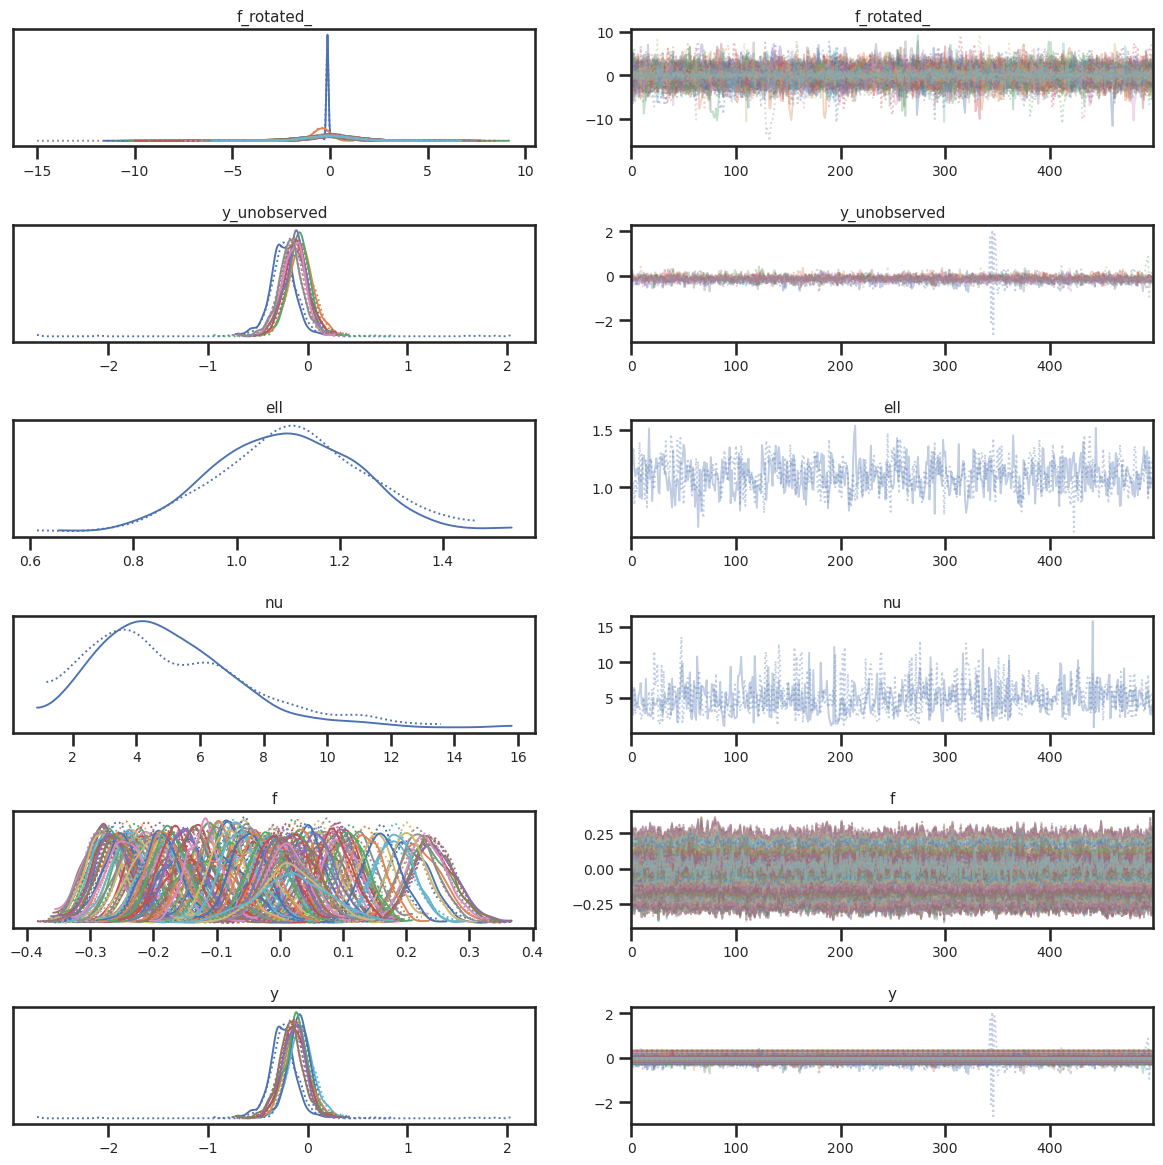

In [34]:
import arviz as az

_ = az.plot_trace(idata)
plt.tight_layout()

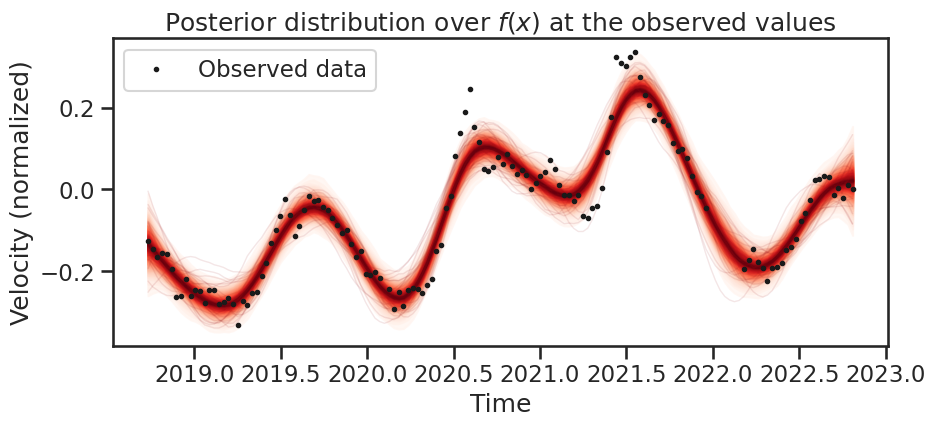

In [35]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

f_post = az.extract(idata, var_names="f").transpose("sample", ...)
plot_gp_dist(ax, f_post, X_slice)

# plot the data and the true latent function
ax.errobar(X_slice, y_slice, yerr_slive, fmt=".k", label="ITSLIVE data")

# axis labels and title
plt.xlabel("Time")
plt.ylabel("Velocity (normalized)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend()

### References


All the references cited here are also attached in the supplementary bibfile.